In [59]:
import pandas as pd
import numpy as np
import re
import glob
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import nltk
import matplotlib.pyplot as plt
import collections
from nltk.util import ngrams

In [31]:
# The data is split between 10 or so CSV files, so we must
# read them individually and combine them.

# Actually, this is far too memory intensive, so we're just 
# going to go with the first one.

path = '/home/dp/russian-troll-tweets'
all_files = glob.glob(path + "/*.csv")
print(all_files)

num_files_to_read = 1
li = []
for index, filename in enumerate(all_files):
    if (index >= num_files_to_read):
        break
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
frame = pd.concat(li, axis=0, ignore_index=True)

df

['/home/dp/russian-troll-tweets/IRAhandle_tweets_10.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_9.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_1.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_11.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_7.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_2.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_12.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_4.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_13.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_8.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_3.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_6.csv', '/home/dp/russian-troll-tweets/IRAhandle_tweets_5.csv']


,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,2260338140,POLITICS_T0DAY,https://t.co/9OgJ5RxUEV,United States,Russian,2/16/2016 23:15,2/16/2016 23:16,92,887,12939,...,Russian,0,NonEnglish,0,2260338140,699733931055259648,http://twitter.com/politics_t0day/statuses/699...,https://twitter.com/politics_t0day/status/6997...,NaN,NaN
1,2260338140,POLITICS_T0DAY,Пять этажей жилого дома рухнули в Ярославле по...,United States,Russian,2/16/2016 5:41,2/16/2016 5:42,92,884,12895,...,Russian,0,NonEnglish,0,2260338140,699468718888390656,http://twitter.com/politics_t0day/statuses/699...,https://youtu.be/STxTIceQmsA,NaN,NaN
2,2260338140,POLITICS_T0DAY,Вербовщика Джихади Джона нашли в Турции через ...,United States,Russian,2/16/2016 6:10,2/16/2016 6:10,92,884,12896,...,Russian,0,NonEnglish,0,2260338140,699476018063659008,http://twitter.com/politics_t0day/statuses/699...,https://youtu.be/xy5ap3xX_fs,NaN,NaN
3,2260338140,POLITICS_T0DAY,"""Война"" с Евгением Поддубным от 14.02.16 https...",United States,Russian,2/16/2016 6:36,2/16/2016 6:36,92,885,12897,...,Russian,0,NonEnglish,0,2260338140,699482457377210372,http://twitter.com/politics_t0day/statuses/699...,https://youtu.be/a7x4v7CYHiA,NaN,NaN
4,2260338140,POLITICS_T0DAY,Посол #САР в #РФ обвинил #США в авиаударах по ...,United States,Russian,2/16/2016 7:01,2/16/2016 7:01,92,885,12898,...,Russian,0,NonEnglish,0,2260338140,699488793993330688,http://twitter.com/politics_t0day/statuses/699...,https://twitter.com/politics_t0day/status/6994...,https://vk.com/wall-62675857_176796,NaN
5,2260338140,POLITICS_T0DAY,В 2016 году начинается масштабная #модернизаци...,United States,Russian,2/16/2016 7:02,2/16/2016 7:02,92,885,12899,...,Russian,0,NonEnglish,0,2260338140,699488942958239744,http://twitter.com/politics_t0day/statuses/699...,https://twitter.com/politics_t0day/status/6994...,https://vk.com/wall-62675857_176809,NaN
6,2260338140,POLITICS_T0DAY,Предательство #СССР. #Перестройка #Хрущёв'а. ...,United States,Russian,2/16/2016 7:02,2/16/2016 7:02,92,885,12900,...,Russian,0,NonEnglish,0,2260338140,699489089805012992,http://twitter.com/politics_t0day/statuses/699...,https://twitter.com/politics_t0day/status/6994...,https://vk.com/wall-62675857_176845,NaN
7,2260338140,POLITICS_T0DAY,"Телеканал ""#Россия"" покажет #фильм-расследован...",United States,Russian,2/16/2016 7:03,2/16/2016 7:03,92,885,12901,...,Russian,0,NonEnglish,0,2260338140,699489262358700032,http://twitter.com/politics_t0day/statuses/699...,https://twitter.com/politics_t0day/status/6994...,https://vk.com/wall-62675857_176863,NaN
8,2260338140,POLITICS_T0DAY,#Поклонская вручила руководству #меджлис'а пре...,United States,Russian,2/16/2016 7:04,2/16/2016 7:04,92,885,12903,...,Russian,0,NonEnglish,0,2260338140,699489549815324674,http://twitter.com/politics_t0day/statuses/699...,https://twitter.com/politics_t0day/status/6994...,https://vk.com/wall-62675857_176892,NaN
9,2260338140,POLITICS_T0DAY,Обиженная #Турция может спровоцировать третью ...,United States,Russian,2/16/2016 7:04,2/16/2016 7:04,92,885,12902,...,Russian,0,NonEnglish,0,2260338140,699489393501933568,http://twitter.com/politics_t0day/statuses/699...,https://twitter.com/politics_t0day/status/6994...,https://vk.com/wall-62675857_176880,NaN


In [32]:
# NLTK has a built-in module for extracting words from text.
# This takes a few minutes to run, so be patient.


nltk.download('punkt')

def remove_punctuation(article):
    # substitute in a regular apostrophe for '’' to word with word_tokenize
    article = article.replace('’', "'")
    tokens = nltk.tokenize.word_tokenize(article)
    words = list(filter(lambda w: any(x.isalpha() for x in w), tokens))
    return " ".join(words)

df['content_no_punctuation'] = df['content'].map(remove_punctuation)
df['content_no_punctuation']

[nltk_data] Downloading package punkt to /home/dp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0                                   https //t.co/9OgJ5RxUEV
1         Пять этажей жилого дома рухнули в Ярославле по...
2         Вербовщика Джихади Джона нашли в Турции через ...
3         Война с Евгением Поддубным от https //t.co/O0P...
4         Посол САР в РФ обвинил США в авиаударах по бол...
5         В году начинается масштабная модернизация обор...
6         Предательство СССР Перестройка Хрущёв а https ...
7         Телеканал Россия покажет фильм-расследование о...
8         Поклонская вручила руководству меджлис а предп...
9         Обиженная Турция может спровоцировать третью м...
10        Лукашенко снова выиграл на антироссийских санк...
11        Альфред Кох объявлен в международный розыск ht...
12        Украинским беженцам предложат переселиться в С...
13        Джеб Буш скрывает информацию о терактах https ...
14        ИГИЛ рассчитывая на резонанс в СМИ выкладывала...
15                                  https //t.co/r6TtComwed
16        Мария Захарова в интервью RT С

In [33]:
# We want to use the 'account_category' column as our y variable. 
# These values take on 6 discrete values: RightTroll, LeftTroll, HashtagGamer, NewsFeed,  Fearmonger, and NonEnglish

y = df['account_category'].tolist()
for i in range(10):
    print(y[i])
y = np.array(y)

NonEnglish
NonEnglish
NonEnglish
NonEnglish
NonEnglish
NonEnglish
NonEnglish
NonEnglish
NonEnglish
NonEnglish


In [34]:
dfX_train, dfX_test, y_train, y_test = train_test_split(df['content_no_punctuation'], y)

# Verify that the shapes look okay
print("df_train.shape",dfX_train.shape)
print("y_train.shape",y_train.shape)
print("dfX_test.shape",dfX_test.shape)
print("y_test.shape",y_test.shape)
print(y_train)

df_train.shape (192833,)
y_train.shape (192833,)
dfX_test.shape (64278,)
y_test.shape (64278,)
['NonEnglish' 'HashtagGamer' 'NewsFeed' ... 'NonEnglish' 'LeftTroll'
 'LeftTroll']


### I noticed that the text sanitization we used in class is insufficient -- a lot of tweets still links and poor grammar. 

Removing URLs with a regex is not straightforward, but we can use string operations to do it. However, after stumbling around with this for 30 minutes, I decided not to pursue it. Leaving links in still gives us some important info. For example, NewsFeed trolls will likely post more links.

In [37]:
def clean_text(s):
    s = s.lower() # Convert to lowercases
    s = re.sub('<br />',' ',s) #Added this new line to get rid of the breaks
    # I tried to add a regex here.
    #s = re.sub('/((([A-Za-z]{3,9}:(?:\/\/)?)(?:[-;:&=\+\$,\w]+@)?[A-Za-z0-9.-]+|(?:www.|[-;:&=\+\$,\w]+@)[A-Za-z0-9.-]+)((?:\/[\+~%\/.\w-_]*)?\??(?:[-\+=&;%@.\w_]*)#?(?:[\w]*))?)/', '', s) 
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s) # Replace all non alphanumeric characters with spaces
    s = re.sub(' +',' ',s) # Replace series of spaces with single space
    return s

def clean_series_data(sdata):
    sdata = list(sdata)
    for i in range(len(sdata)):
        sdata[i] = clean_text(sdata[i])
        if i%(len(sdata)/5)==0:
            print(sdata[i]) #Printing occasional text can be helpful for making sure that your cleaning is working how you want it to. Or you can comment this out.
    return sdata

# remove things like punctuation, capitalization, and links
dfX_train = clean_series_data(dfX_train)
dfX_test = clean_series_data(dfX_test)

https t co lhs2z74xpi
new rocky story creed balances brutality and theatricality https t co 1gxxqkue93 entertainment


In [39]:
# confirm that the text was properly cleaned
for i in range(20):
    print(dfX_train[i])
    print(y_train[i], '\n')

https t co lhs2z74xpi
NonEnglish 

toavoidworki make my employees do all the work for me
HashtagGamer 

forced labor shows back breaking lack of reform in myanmar military world news
NewsFeed 

 https t co odi0qtyu69
NonEnglish 

one pilot killed another injured after helicopter crash at russian airshow world news
NewsFeed 

 1965 https t co cjwh9fl3s9
NonEnglish 

igetdepressedwhen theres no food in the house
HashtagGamer 

 microsoft https t co hb5tfnk6yo
NonEnglish 

 https t co rygowqkn9t http t co ax9rkrlthq
NonEnglish 

2016in4words hoped to succeed failed https t co ju3phdxftv
HashtagGamer 

mt esmeraldakiczek lord transform culture of death into one of life praytoendabortion https t co etgyfpwmkt unbornlivesmatter pjnet
RightTroll 

who should get donkeyoftheday today let me know breakfastclubam click here to stream us live https t co vw3ty6awpa
LeftTroll 

sears hitches a ride with uber to make rewards plan more attractive tech
NewsFeed 

 https t co tsdtbeobfr https t co ijio

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

ngramvectorizer = CountVectorizer(binary=True, ngram_range=(2,2), min_df=20, tokenizer=lambda x: x.split(' '))
ngramvectorizer.fit(dfX_train)

X_train_ngram = ngramvectorizer.transform(dfX_train)
X_test_ngram = ngramvectorizer.transform(dfX_test)
print("X_train_ngram.shape", X_train_ngram.shape)
print("X_test_ngram.shape", X_test_ngram.shape) 

X_train_ngram.shape (192833, 7257)
X_test_ngram.shape (64278, 7257)


In [41]:
# Actually run the model and print results
# If this is taking too long, you can run it on a subset of your data.
model = MultinomialNB(alpha=1)
model.fit(X_train_ngram, y_train)

y_pred_train = model.predict(X_train_ngram)
print("Training accuracy: ", np.mean(y_pred_train == y_train))
y_pred = model.predict(X_test_ngram)
print("Testing accuracy: ",np.mean(y_pred == y_test))

Training accuracy:  0.7998734656412544
Testing accuracy:  0.7872522480475435


### The first iteration of our model achieved roughly 79% accuracy in predicting the account category using bigrams.

It would be interesting to scan the space of (low_n_bound, high_n_bound) in n-grams to see how that impacts accuracy. 

In [52]:
def getAccuracy(lower_bound, higher_bound):
    ngramvectorizer = CountVectorizer(binary=True, ngram_range=(lower_bound,higher_bound), min_df=20, tokenizer=lambda x: x.split(' '))
    ngramvectorizer.fit(dfX_train)
    X_train_ngram = ngramvectorizer.transform(dfX_train)
    X_test_ngram = ngramvectorizer.transform(dfX_test)
    
    model = MultinomialNB(alpha=1)
    model.fit(X_train_ngram, y_train)
    
    print("\nResults for ", lower_bound, ",", higher_bound, ":")
    y_pred_train = model.predict(X_train_ngram)
    print("Training accuracy: ", np.mean(y_pred_train == y_train))
    y_pred = model.predict(X_test_ngram)
    print("Testing accuracy: ",np.mean(y_pred == y_test))
    return np.mean(y_pred == y_test)

n = 7
m = 7
results = np.zeros(shape=(n, m))
for lower_bound in range(1, n+1):
    for higher_bound in range(lower_bound, m+1):
        results[lower_bound - 1][higher_bound - 1] = getAccuracy(lower_bound, higher_bound)
print(results)
        


Results for  1 , 1 :
Training accuracy:  0.8740723838762038
Testing accuracy:  0.8641525871993528

Results for  1 , 2 :
Training accuracy:  0.8716298558856628
Testing accuracy:  0.8601076573633281

Results for  1 , 3 :
Training accuracy:  0.8690265670295022
Testing accuracy:  0.8576029123494819

Results for  1 , 4 :
Training accuracy:  0.8688139478201345
Testing accuracy:  0.8571361896760945

Results for  1 , 5 :
Training accuracy:  0.8688035761513849
Testing accuracy:  0.857167304520987

Results for  1 , 6 :
Training accuracy:  0.8687569036420115
Testing accuracy:  0.8570584025638632

Results for  1 , 7 :
Training accuracy:  0.8687154169670129
Testing accuracy:  0.8570117302965244

Results for  2 , 2 :
Training accuracy:  0.7998734656412544
Testing accuracy:  0.7872522480475435

Results for  2 , 3 :
Training accuracy:  0.7972598051163442
Testing accuracy:  0.7863499175456611

Results for  2 , 4 :
Training accuracy:  0.7989140862819123
Testing accuracy:  0.7872522480475435

Results fo

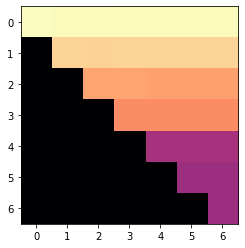

In [83]:
plt.imshow(results, cmap='magma', interpolation='nearest')
plt.show()

There seems to be a pretty clear pattern: a lower value for the lower bound will produce the highest accuracy. The upper bound does not seem to affect the results much. 

# Which ngrams are most associated with each type of poster?

In [77]:
wordsPerCategory = {}
n = 2

for i in range(len(y_train)):
    tokens = [token for token in dfX_train[i].split(" ") if token != ""]
    if y_train[i] in wordsPerCategory:
        wordsPerCategory[y_train[i]].extend(tokens)
    else:
        wordsPerCategory[y_train[i]] = tokens

for key in wordsPerCategory:
    print(key)
    
    ngramWords = wordsPerCategory[key]
    words = list(ngrams(ngramWords, n))
    ngramFreq = collections.Counter(words)
    
    #print(key, " bigrams:")
    mostCommon = ngramFreq.most_common(10)
    for common in mostCommon:
        print(common)

NonEnglish
(('t', 'co'), 87313)
(('https', 't'), 74570)
(('http', 't'), 12744)
(('youtube', 'https'), 734)
(('2016', 'https'), 330)
(('2', 'https'), 232)
(('russia', 'https'), 225)
(('24', 'https'), 222)
(('rus', 'improvisation'), 221)
(('improvisation', 'https'), 192)
HashtagGamer
(('t', 'co'), 1472)
(('https', 't'), 1083)
(('n', 't'), 455)
(('http', 't'), 391)
(('i', 'm'), 212)
(('do', 'n'), 196)
(('in', 'the'), 155)
(('it', 's'), 152)
(('of', 'the'), 110)
(('you', 're'), 101)
NewsFeed
(('world', 'news'), 20236)
(('t', 'co'), 19508)
(('https', 't'), 15937)
(('u', 's'), 6411)
(('http', 't'), 3570)
(('news', 'topnews'), 3281)
(('sports', 'topnews'), 1471)
(('islamic', 'state'), 1187)
(('topnews', 'u'), 1016)
(('news', 'us'), 989)
RightTroll
(('t', 'co'), 18870)
(('https', 't'), 15602)
(('http', 't'), 3301)
(('n', 't'), 1886)
(('it', 's'), 782)
(('do', 'n'), 636)
(('of', 'the'), 624)
(('ros', 'https'), 593)
(('in', 'the'), 589)
(('is', 'a'), 453)
LeftTroll
(('t', 'co'), 21871)
(('https'

'\nbigramWordsPositive = list(ngrams(wordsPositive, n))\nbigramFreqPositive = collections.Counter(bigramWordsPositive)\nbigramWordsNegative = list(ngrams(wordsNegative, n))\nbigramFreqNegative = collections.Counter(bigramWordsNegative)\n\nprint("Positive bigrams:")\nbgfp = bigramFreqPositive.most_common(10)\nfor bg in bgfp:\n  print(bg)\nprint(\'\n\')\nprint("Negative bigrams")\nbgfp = bigramFreqNegative.most_common(10)\nfor bg in bgfp:\n  print(bg)\n'

## TODO: 
* Combine multiple CSV files into one for more data. Potentially explore how the number of data points impacts accuracy?
    * This crashes the notebook and doesn't contribute that much anyways.